### __Classifying ORL faces using PCA and L2 distance__

#### High level steps are as follow
- Read in data, flatten images, separate train (80%) and test (20%), generate labels
- Find Covariance matrix of train data = AA_t
- Get eigenvalues of covariance matrix
- Find k eigenvectors that are responsible for 90% of the variance
- Project train and test data onto eigenspace (get weights)
- Calculate L2 distance between each test image and all train images
- Select the index of min distance for each test image to find closest match (according to eigenspace)
- Calculate accuracy of distance classifier

In [1]:
#Data preprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import time

X = []
y = []


for f in glob.iglob('data/**/**'):
    X.append(np.array(cv2.imread(f, cv2.IMREAD_GRAYSCALE)).flatten().tolist())
    index = int(f.split("\\")[-2].split("s")[1])
    y.append(index)


data_set = [(X[i], y[i]) for i in range(len(y))]

data_set.sort(key= lambda x: x[1])

train = []
test = []

for i, item in enumerate(data_set):
    if i % 10 > 7:
        test.append(item)
    else:
        train.append(item)

train

train_X = np.array([X[0] + [X[1]] for X in train], dtype=float)[:, :-1].T
train_X = train_X - np.mean(train_X, axis=1).reshape((-1, 1))
train_y = np.array([X[0] + [X[1]] for X in train])[:, -1]

test_X = np.array([X[0] + [X[1]] for X in test], dtype=float)[:, :-1].T
test_X = test_X - np.mean(test_X, axis=1).reshape((-1, 1))
test_y = np.array([X[0] + [X[1]] for X in test])[:, -1]


(10304,)


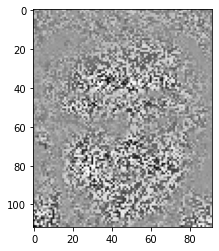

In [2]:
#Visualize average face

plt.imshow(np.mean(train_X, axis=1).reshape((-1, 92)), cmap='Greys')

In [3]:
#Cov matrix of train data.  Doing A_T @ A instead of the other way around bc computationally efficient
cov_mat = train_X.T @ train_X
w, v = np.linalg.eig(cov_mat)

In [32]:
#Calculate number of PC that captures 90% of variance
sum = np.sum(w)
running_sum = 0
k = int()
for i in range(w.shape[0]):
    running_sum += w[i]
    if running_sum >= .9 * sum:
        k = i
        break

sorted_idx = np.flip(np.argsort(w))

top_k_eigvs = w[sorted_idx][:k]

top_k_eigs = v[:, sorted_idx][:, :k]

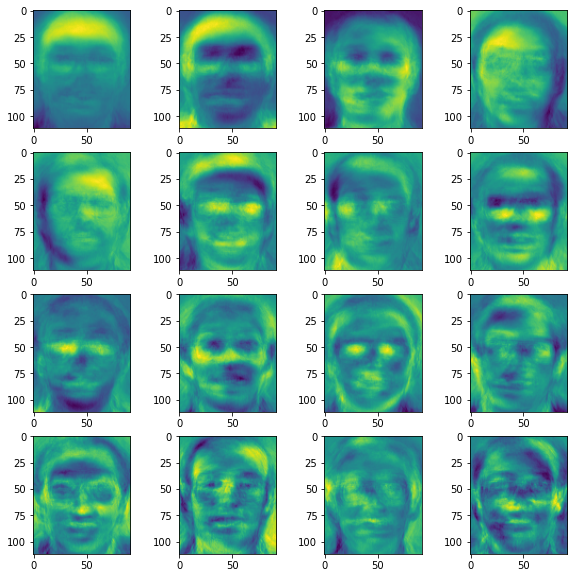

In [51]:
#Transform eigenvectors back to original space. Av = u

top_k_eigs = train_X @ top_k_eigs

#Print top 16 eigenfaces

fig, ax = plt.subplots(4,4)

for i in range(16):
    ax[int(i / 4)][i % 4].imshow(top_k_eigs[:, i].reshape(112,92))

fig.set_size_inches(10, 10)



In [53]:
#Get weights for images in train set, each row is a training image's weights
dataset_weights = train_X.T @ top_k_eigs

Accuracy: 0.9375


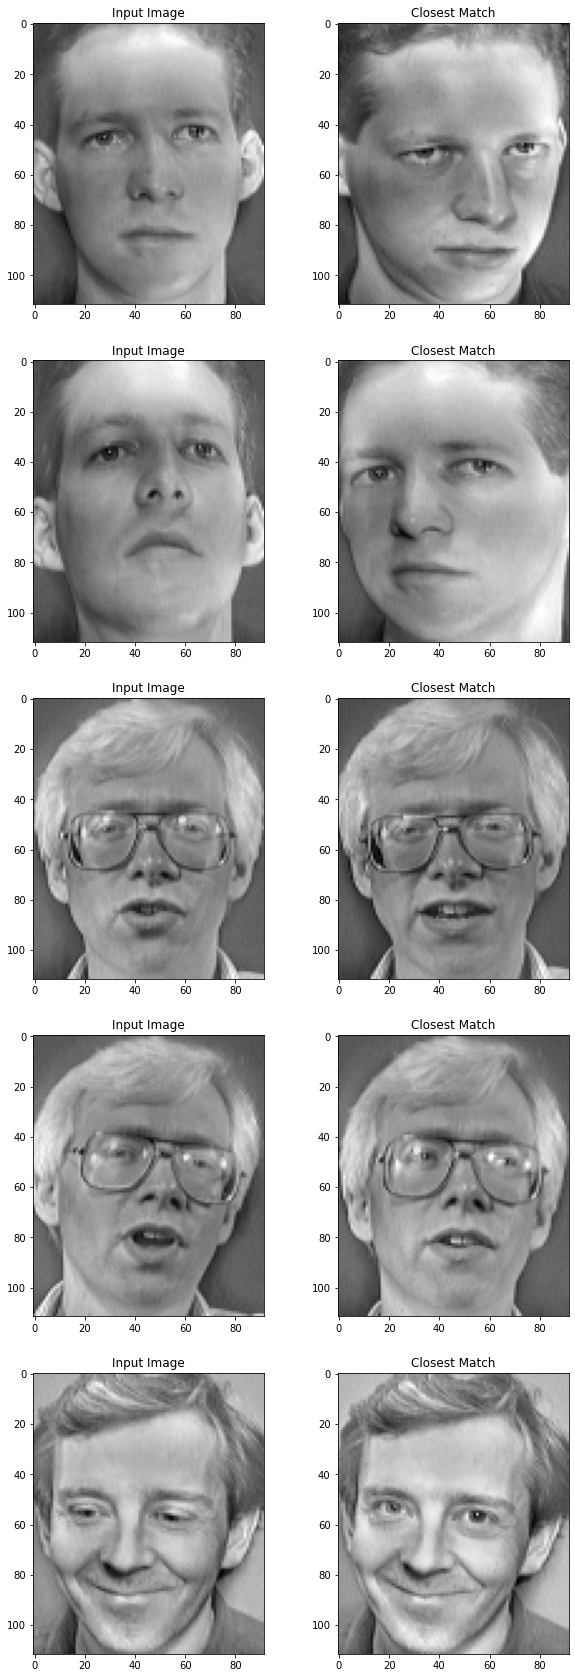

In [99]:
#Test it out
test_weights = test_X.T @ top_k_eigs

fig, ax = plt.subplots(5,2)
guessed_correctly = 0
for i in range(test_weights.shape[0]):
    distances = np.linalg.norm(dataset_weights - test_weights[i, :], axis=1)
    idx_max_match = np.argmin(distances)
    if test_y[i] == train_y[idx_max_match]:
        guessed_correctly += 1
    if i < 5:
        ax[i][0].imshow(test_X[:, i].reshape(112, 92), cmap="gray")
        ax[i][1].imshow(train_X[:, idx_max_match].reshape(112, 92), cmap="gray")
        ax[i][0].set_title("Input Image")
        ax[i][1].set_title("Closest Match")

print(f"Accuracy: {guessed_correctly / test_weights.shape[0]}")

fig.set_size_inches(10, 30)

#### References

1. https://machinelearningmastery.com/face-recognition-using-principal-component-analysis/
2. https://www.geeksforgeeks.org/ml-face-recognition-using-eigenfaces-pca-algorithm/